In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"uswashariq","key":"0a4766a1cb2cff7a9edcd43c4024088a"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle

In [ ]:
!kaggle datasets download -d mmuzamil/real-and-fake-currency-pakistanis-dataset -p data_pkr

Dataset URL: https://www.kaggle.com/datasets/mmuzamil/real-and-fake-currency-pakistanis-dataset
License(s): unknown
 99% 1.14G/1.15G [00:11<00:00, 115MB/s] 
100% 1.15G/1.15G [00:11<00:00, 107MB/s]


In [ ]:
!unzip -q data_pkr/real-and-fake-currency-pakistanis-dataset.zip -d data_pkr

In [ ]:
# 1) See what type of file it is
!file "data_pkr/Real And  Fake Currency Dataset"

# 2) Try to unzip it into a new folder "inner"
!mkdir -p data_pkr/inner
!unzip -q "data_pkr/Real And  Fake Currency Dataset" -d data_pkr/inner || echo "unzip failed"

# 3) Show all folders up to depth 3 so we can see where things are
!find data_pkr -maxdepth 3 -type d -print

data_pkr/Real And  Fake Currency Dataset: Zip archive data, at least v1.0 to extract, compression method=store
data_pkr
data_pkr/inner
data_pkr/inner/Fake Notes
data_pkr/inner/Real Notes


In [ ]:
# Create final folders
!mkdir -p data_pkr/real data_pkr/fake

# Move real images
!mv "data_pkr/inner/Real Notes"/* data_pkr/real/

# Move fake images
!mv "data_pkr/inner/Fake Notes"/* data_pkr/fake/

# Verify
print("Real images:", len(list(__import__("os").listdir("data_pkr/real"))))
print("Fake images:", len(list(__import__("os").listdir("data_pkr/fake"))))

!ls data_pkr/real | head
!ls data_pkr/fake | head

Real images: 950
Fake images: 650
Real-Notes (100).jpg
Real-Notes (101).jpg
Real-Notes (102).jpg
Real-Notes (103).jpg
Real-Notes (104).jpg
Real-Notes (105).jpg
Real-Notes (106).jpg
Real-Notes (107).jpg
Real-Notes (108).jpg
Real-Notes (109).jpg
fakes-Notes (100).jpg
fakes-Notes (101).jpg
fakes-Notes (102).jpg
fakes-Notes (103).jpg
fakes-Notes (104).jpg
fakes-Notes (105).jpg
fakes-Notes (106).jpg
fakes-Notes (107).jpg
fakes-Notes (108).jpg
fakes-Notes (109).jpg


In [ ]:
import os
import shutil

root = "data_pkr"

# Make class folders if not exist
os.makedirs(f"{root}/real", exist_ok=True)
os.makedirs(f"{root}/fake", exist_ok=True)

# Move images into the right folders
for f in os.listdir(root):
    path = os.path.join(root, f)

    if os.path.isfile(path):
        fname = f.lower()

        if "real" in fname:
            shutil.move(path, f"{root}/real/{f}")
        elif "fake" in fname or "fakes" in fname:
            shutil.move(path, f"{root}/fake/{f}")


In [ ]:
!ls data_pkr/real | head
!ls data_pkr/fake | head

Real And  Fake Currency Dataset
real-and-fake-currency-pakistanis-dataset.zip
Real-Notes (100).jpg
Real-Notes (101).jpg
Real-Notes (102).jpg
Real-Notes (103).jpg
Real-Notes (104).jpg
Real-Notes (105).jpg
Real-Notes (106).jpg
Real-Notes (107).jpg
fakes-Notes (100).jpg
fakes-Notes (101).jpg
fakes-Notes (102).jpg
fakes-Notes (103).jpg
fakes-Notes (104).jpg
fakes-Notes (105).jpg
fakes-Notes (106).jpg
fakes-Notes (107).jpg
fakes-Notes (108).jpg
fakes-Notes (109).jpg


In [ ]:
!rm -rf data_pkr/inner
!ls data_pkr

fake  real


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
DATA_DIR = "data_pkr"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)


In [ ]:
train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

Found 1280 images belonging to 2 classes.


In [ ]:
val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False    # keep order fixed for evaluation
)


Found 320 images belonging to 2 classes.


In [ ]:
print("Class indices:", train_gen.class_indices)

Class indices: {'fake': 0, 'real': 1}


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')   # 0 = fake, 1 = real
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 240s 6s/step - accuracy: 0.5885 - loss: 0.9088 - val_accuracy: 0.7688 - val_loss: 0.4889
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 241s 6s/step - accuracy: 0.7455 - loss: 0.5144 - val_accuracy: 0.7000 - val_loss: 0.4953
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 220s 5s/step - accuracy: 0.7798 - loss: 0.4747 - val_accuracy: 0.8281 - val_loss: 0.4589
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 230s 6s/step - accuracy: 0.8229 - loss: 0.4012 - val_accuracy: 0.7906 - val_loss: 0.5618
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 240s 6s/step - accuracy: 0.8478 - loss: 0.3567 - val_accuracy: 0.7406 - val_loss: 0.5658
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 233s 6s/step - accuracy: 0.8561 - loss: 0.3574 - val_accuracy: 0.7625 - val_loss: 0.5517
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 225s 6s/step - accuracy: 0.8706 - loss: 0.3193 - val_accuracy: 0.7844 - val_loss: 0.6034
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 220s 5s/step - accuracy: 0.8686 - loss: 0.3156 - val_accuracy: 0.8313 - v

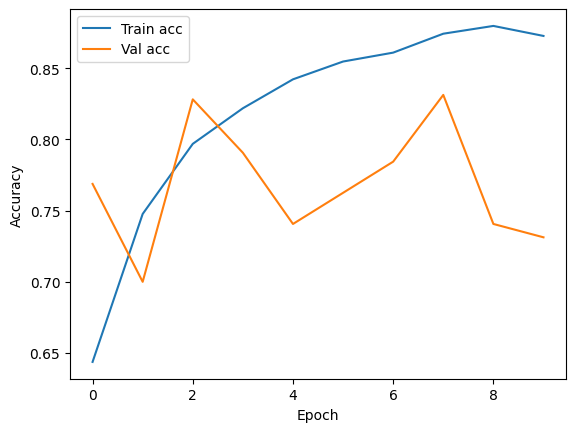

In [ ]:
# Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

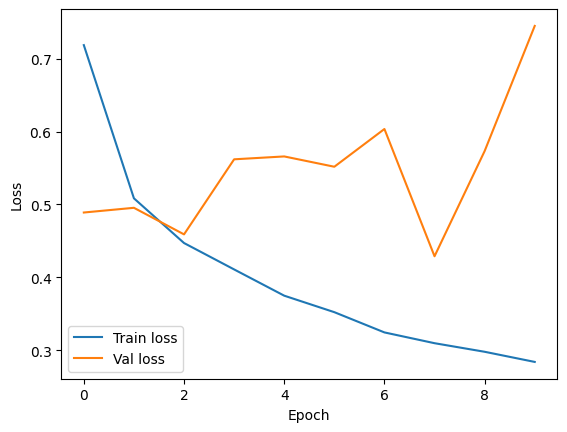

In [ ]:
# Loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the trained model
model.save("currency_cnn_pkr.h5")
print("Model saved as currency_cnn_pkr.h5")

Model saved as currency_cnn_pkr.h5


In [ ]:
# Predictions on validation set
val_gen.reset()
y_pred_prob = model.predict(val_gen)
y_pred = (y_pred_prob.ravel() >= 0.5).astype(int)

10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step


In [ ]:
y_true = val_gen.classes
target_names = list(val_gen.class_indices.keys())

In [ ]:
print("Class mapping:", val_gen.class_indices)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

Class mapping: {'fake': 0, 'real': 1}

Classification Report:

              precision    recall  f1-score   support

        fake       0.89      0.39      0.55       130
        real       0.70      0.97      0.81       190

    accuracy                           0.73       320
   macro avg       0.80      0.68      0.68       320
weighted avg       0.78      0.73      0.70       320



In [ ]:
model.save("currency_model.h5")

In [ ]:
!pip install gradio

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import gradio as gr

In [ ]:
model = load_model("currency_model.h5")

In [ ]:
IMG_SIZE = (224, 224)

def predict_currency(img):
    # Resize to training size
    img = img.resize(IMG_SIZE)

    # Convert to array and scale
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prob = model.predict(img_array)[0][0]   # scalar between 0 and 1

    if prob >= 0.5:
        label = "Real Currency Note"
        confidence = prob
    else:
        label = "Fake Currency Note"
        confidence = 1 - prob

    # 👉 Return TWO values: (label, confidence%)
    return label, round(float(confidence) * 100, 2)

In [ ]:
demo = gr.Interface(
    fn=predict_currency,
    inputs=gr.Image(type="pil", label="Upload PKR currency note"),
    outputs=[
        gr.Textbox(label="Prediction"),
        gr.Number(label="Confidence (%)")
    ],
    title="Pakistani Currency Real/Fake Detector",
    description="Upload an image of a Pakistani currency note to check whether it is real or fake."
)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c76823d863c4bf541c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


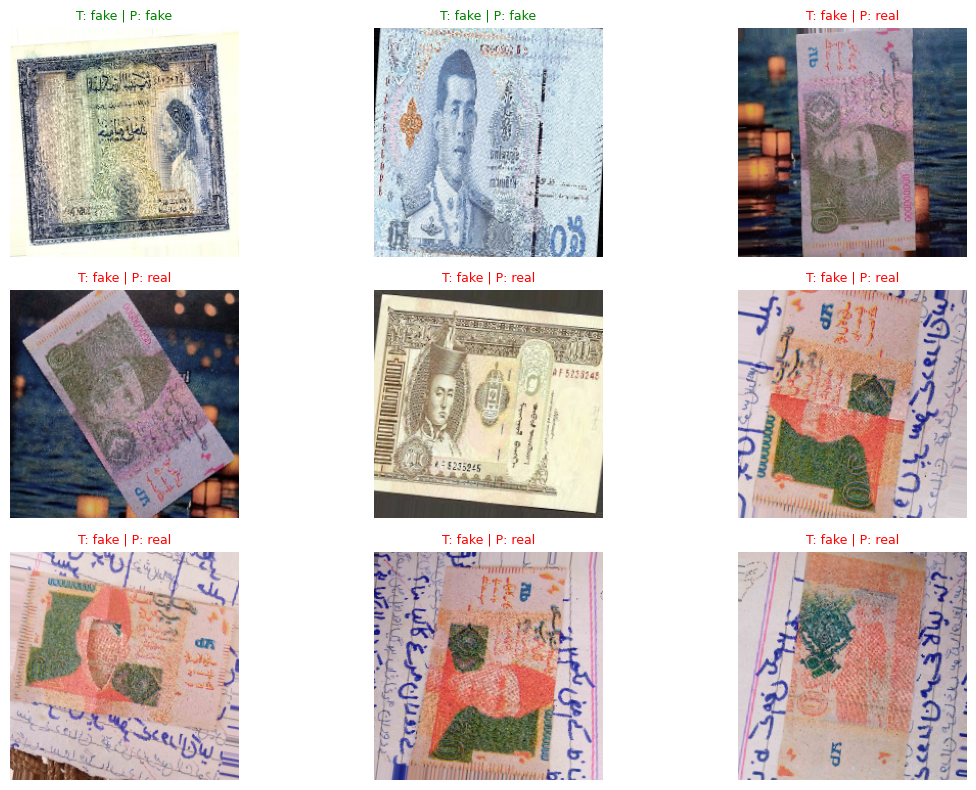

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['fake', 'real']  # 0 -> fake, 1 -> real

# get one batch from validation generator
images, labels = next(val_gen)   # val_gen you already created

# model predictions
pred_probs = model.predict(images)
pred_labels = (pred_probs.ravel() >= 0.5).astype(int)

plt.figure(figsize=(12, 8))
for i in range(9):  # show 9 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    true_label = class_names[int(labels[i])]
    pred_label = class_names[int(pred_labels[i])]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"T: {true_label} | P: {pred_label}", color=color, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# after training
model.save("currency_model.h5")
!ls -lh currency_model.h5

-rw-r--r-- 1 root root 43M Dec  1 18:09 currency_model.h5


In [ ]:
# Install web frameworks + utils
!pip install -q streamlit flask fastapi uvicorn pillow python-multipart

# Download cloudflared (for public URL, no account needed)
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!mv cloudflared-linux-amd64 cloudflared
!chmod +x cloudflared

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 39.1 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import load_model

# assuming you already have `model` in memory
model.save("currency_model(1).h5", save_format="h5")

!ls -lh currency_model.h5  # check size – should be tens of MB, not a few KB

-rw-r--r-- 1 root root 43M Dec  1 18:09 currency_model.h5


In [ ]:
from tensorflow.keras.models import load_model

test_model = load_model("currency_model(1).h5", compile=False)
print("Model loaded successfully in plain Python!")

Model loaded successfully in plain Python!


**STREAMLIT**

In [ ]:
%%writefile streamlit_app.py
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load model once at app start
model = load_model("currency_model(1).h5")
IMG_SIZE = (224, 224)

def predict(img: Image.Image):
    # preprocess
    img = img.convert("RGB")
    img = img.resize(IMG_SIZE)
    arr = np.array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)
    # predict
    pred = model.predict(arr)[0][0]
    if pred >= 0.5:
        label = "Real Currency Note"
        confidence = pred * 100
    else:
        label = "Fake Currency Note"
        confidence = (1 - pred) * 100
    return label, float(confidence)

st.title("🇵🇰 Pakistani Currency Real/Fake Detector")

uploaded = st.file_uploader("Upload a PKR note image", type=["jpg", "jpeg", "png"])
if uploaded is not None:
    img = Image.open(uploaded)
    st.image(img, caption="Uploaded note", width=350)

    label, conf = predict(img)
    st.success(f"Prediction: **{label}**")
    st.info(f"Confidence: **{conf:.2f}%**")
else:
    st.write("Please upload an image.")


Writing streamlit_app.py


In [ ]:
# Run streamlit in background on port 7860
!nohup streamlit run streamlit_app.py --server.address 0.0.0.0 --server.port 7860 >/dev/null 2>&1 &

# Expose it to internet via cloudflared
!./cloudflared tunnel --url http://0.0.0.0:7860 --no-autoupdate

2025-12-01T18:09:35Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-12-01T18:09:35Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-12-01T18:09:38Z INF +--------------------------------------------------------------------------------------------+
2025-12-01T18:09:38Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-12-01T18:09:38Z INF |  https://responding-rose-protocols-supplies.trycloudfl

**FLASK**

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("currency_model.h5")
print("Model loaded, params:", model.count_params())

Model loaded, params: 11169089


In [ ]:
!nohup python flask_app.py > flask_log.txt 2>&1 &

In [ ]:
%%writefile flask_app.py
import io
import numpy as np
from PIL import Image
import tensorflow as tf
from flask import Flask, request, render_template_string

# ---------- Model & Preprocessing ----------
IMG_SIZE = (224, 224)

model = tf.keras.models.load_model("currency_model(1).h5")
# index 0 = fake, 1 = real  (same as your generator)
class_names = ["Fake Currency Note", "Real Currency Note"]

def predict_image(img: Image.Image):
    img = img.convert("RGB")
    img = img.resize(IMG_SIZE)
    arr = np.array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)
    preds = model.predict(arr)[0]
    idx = int(np.argmax(preds))
    conf = float(preds[idx] * 100)
    label = class_names[idx]
    return label, conf

# ---------- Flask App ----------
app = Flask(__name__)

HTML_PAGE = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8" />
    <title>PKR Currency Real/Fake Detector · Flask</title>
    <style>
        :root {
            --bg: #020617;
            --bg-soft: #020617dd;
            --card: #020617;
            --accent: #38bdf8;
            --accent-soft: #0ea5e9;
            --border: #1f2937;
            --text-main: #e5e7eb;
            --text-muted: #9ca3af;
            --danger: #fb7185;
            --success: #22c55e;
        }
        * { box-sizing: border-box; }
        body {
            margin: 0;
            font-family: system-ui, -apple-system, BlinkMacSystemFont, "Segoe UI", sans-serif;
            background: radial-gradient(circle at top left, #0f172a, #020617 50%, #0b1120 100%);
            color: var(--text-main);
        }
        .page {
            min-height: 100vh;
            display: flex;
            align-items: center;
            justify-content: center;
            padding: 32px 16px;
        }
        .card {
            width: 100%;
            max-width: 960px;
            background: var(--bg-soft);
            border-radius: 24px;
            border: 1px solid var(--border);
            box-shadow: 0 24px 80px rgba(15, 23, 42, 0.9);
            padding: 32px 28px 28px;
        }
        .header {
            display: flex;
            align-items: center;
            gap: 12px;
            margin-bottom: 24px;
        }
        .logo-pill {
            width: 40px;
            height: 40px;
            border-radius: 999px;
            background: linear-gradient(135deg, #22c55e, #38bdf8);
            display: flex;
            align-items: center;
            justify-content: center;
            font-weight: 700;
            font-size: 20px;
            color: #0b1120;
        }
        h1 {
            margin: 0;
            font-size: 26px;
            letter-spacing: 0.02em;
        }
        .subtitle {
            margin-top: 2px;
            font-size: 14px;
            color: var(--text-muted);
        }
        .grid {
            display: grid;
            grid-template-columns: minmax(0, 1.4fr) minmax(0, 1fr);
            gap: 24px;
        }
        @media (max-width: 800px) {
            .grid { grid-template-columns: minmax(0,1fr); }
        }
        .upload-card, .result-card {
            background: rgba(15, 23, 42, 0.75);
            border-radius: 18px;
            border: 1px solid var(--border);
            padding: 18px 18px 20px;
        }
        .section-title {
            font-size: 15px;
            font-weight: 600;
            margin-bottom: 6px;
        }
        .section-caption {
            font-size: 13px;
            color: var(--text-muted);
            margin-bottom: 14px;
        }
        .upload-box {
            border-radius: 16px;
            border: 1px dashed rgba(148, 163, 184, 0.7);
            padding: 22px 16px;
            text-align: center;
            background: rgba(15, 23, 42, 0.7);
        }
        .upload-box:hover {
            border-color: var(--accent);
            background: rgba(15, 23, 42, 0.9);
        }
        .upload-box input[type="file"] {
            display: block;
            margin: 10px auto 6px;
            cursor: pointer;
            color: var(--text-muted);
        }
        .helper-text {
            font-size: 12px;
            color: var(--text-muted);
        }
        .btn {
            margin-top: 14px;
            display: inline-flex;
            align-items: center;
            justify-content: center;
            padding: 10px 18px;
            border-radius: 999px;
            border: none;
            font-size: 14px;
            font-weight: 500;
            background: linear-gradient(135deg, var(--accent), var(--accent-soft));
            color: #020617;
            cursor: pointer;
            box-shadow: 0 12px 30px rgba(56, 189, 248, 0.45);
        }
        .btn:hover {
            filter: brightness(1.05);
            box-shadow: 0 18px 40px rgba(56, 189, 248, 0.6);
        }
        .btn:active {
            transform: translateY(1px);
            box-shadow: 0 8px 20px rgba(56, 189, 248, 0.35);
        }
        .result-empty {
            font-size: 13px;
            color: var(--text-muted);
            margin-top: 4px;
        }
        .tag {
            display: inline-flex;
            align-items: center;
            gap: 6px;
            padding: 4px 12px;
            border-radius: 999px;
            font-size: 12px;
            font-weight: 600;
        }
        .tag-real {
            background: rgba(34, 197, 94, 0.1);
            color: #bbf7d0;
            border: 1px solid rgba(34, 197, 94, 0.7);
        }
        .tag-fake {
            background: rgba(248, 113, 113, 0.12);
            color: #fecaca;
            border: 1px solid rgba(248, 113, 113, 0.7);
        }
        .result-label {
            margin-top: 10px;
            font-size: 19px;
            font-weight: 600;
        }
        .confidence {
            margin-top: 8px;
            font-size: 14px;
        }
        .confidence span {
            font-weight: 600;
            color: var(--accent);
        }
        .footer-note {
            margin-top: 12px;
            font-size: 11px;
            color: var(--text-muted);
        }
    </style>
</head>
<body>
<div class="page">
    <div class="card">
        <div class="header">
            <div class="logo-pill">PK</div>
            <div>
                <h1>Pakistani Currency Real/Fake Detector</h1>
                <div class="subtitle">Upload a PKR note image to verify whether it looks genuine or counterfeit.</div>
            </div>
        </div>

        <div class="grid">
            <!-- Upload side -->
            <div class="upload-card">
                <div class="section-title">1 · Upload PKR note image</div>
                <div class="section-caption">Supported formats: JPG, JPEG, PNG (up to ~5MB in Colab).</div>
                <form method="POST" enctype="multipart/form-data">
                    <div class="upload-box">
                        <input type="file" name="file" accept="image/*" required />
                        <div class="helper-text">Click to choose an image from your device.</div>
                    </div>
                    <button class="btn" type="submit">Analyse Note</button>
                </form>
            </div>

            <!-- Result side -->
            <div class="result-card">
                <div class="section-title">2 · Result</div>
                {% if result %}
                    <div class="section-caption">AI model prediction based on visual features of the uploaded note.</div>
                    <div class="tag {{ label_class }}">
                        {% if 'Real' in result %}
                            <span>●</span> Real Currency
                        {% else %}
                            <span>●</span> Suspected Fake
                        {% endif %}
                    </div>
                    <div class="result-label">{{ result }}</div>
                    <div class="confidence">
                        Confidence score: <span>{{ '%.2f'|format(confidence or 0.0) }}%</span>
                    </div>
                    <div class="footer-note">
                        This is an AI-based assistance only. Always verify with official sources for legal or financial decisions.
                    </div>
                {% else %}
                    <div class="section-caption">No prediction yet.</div>
                    <div class="result-empty">
                        Upload a currency note on the left and click <b>Analyse Note</b> to see the prediction here.
                    </div>
                {% endif %}
            </div>
        </div>
    </div>
</div>
</body>
</html>
"""

@app.route("/", methods=["GET", "POST"])
def index():
    result = None
    confidence = None
    label_class = ""

    if request.method == "POST":
        if "file" in request.files:
            file = request.files["file"]
            if file and file.filename != "":
                img_bytes = file.read()
                img = Image.open(io.BytesIO(img_bytes))
                result, confidence = predict_image(img)
                # Choose badge color
                label_class = "tag-real" if "Real" in result else "tag-fake"
            else:
                result = "No selected file"
                label_class = "tag-fake"

    return render_template_string(
        HTML_PAGE,
        result=result,
        confidence=confidence,
        label_class=label_class
    )

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000, debug=False)


Overwriting flask_app.py


In [ ]:
!./cloudflared tunnel --url http://localhost:5000 --no-autoupdate

2025-12-01T18:15:52Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-12-01T18:15:52Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-12-01T18:15:56Z INF +--------------------------------------------------------------------------------------------+
2025-12-01T18:15:56Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-12-01T18:15:56Z INF |  https://chef-rob-means-vocals.trycloudflare.com      

**FLASKAPI**

In [ ]:
!mkdir -p static
!mkdir -p templates

In [ ]:
%%writefile static/style.css
/* Your full CSS here */

Overwriting static/style.css


In [ ]:
%%writefile templates/index.html
<!-- Your full HTML here -->

Overwriting templates/index.html


In [ ]:
!lsof -i :7860

In [ ]:
!kill -9 1234

/bin/bash: line 1: kill: (1234) - No such process


In [ ]:
!fuser -k 7860/tcp

In [ ]:
!fuser -k 7860/tcp || true      # kill anything on port 7860
!pkill -f cloudflared || true   # stop any old cloudflared processes

^C


In [ ]:
fastapi_code = '''
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import HTMLResponse
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import io

model = load_model("currency_model(1).h5")
IMG_SIZE = (224, 224)

app = FastAPI()

def preprocess(img):
    img = img.convert("RGB").resize(IMG_SIZE)
    arr = np.array(img) / 255.0
    return np.expand_dims(arr, axis=0)

def predict_image(img):
    x = preprocess(img)
    pred = float(model.predict(x)[0][0])
    if pred >= 0.5:
        return "Real Currency Note", pred * 100
    else:
        return "Fake Currency Note", (1 - pred) * 100

HTML_PAGE = """
<!DOCTYPE html>
<html>
<head>
<style>
body { font-family:Arial; background:#f5f5f5; padding:0; margin:0; }
.container { max-width:900px; margin:40px auto; background:#fff; padding:30px;
             border-radius:12px; box-shadow:0 10px 20px rgba(0,0,0,0.1); }
h1 { text-align:center; }
.upload { border:2px dashed #ccc; padding:25px; text-align:center; cursor:pointer; }
.result { font-size:22px; text-align:center; margin-top:25px; font-weight:600; }
</style>
</head>

<body>
<div class="container">
    <h1>PKR Currency Real/Fake Detector</h1>

    <form action="/predict" method="post" enctype="multipart/form-data">
        <label class="upload">
            Click to upload PKR note
            <input type="file" name="file" accept="image/*"
                   style="display:none" onchange="this.form.submit()">
        </label>
    </form>

    <div class="result">
        Prediction: {result} <br>
        Confidence: {confidence}%
    </div>
</div>
</body>
</html>
"""

@app.get("/", response_class=HTMLResponse)
async def index():
    return HTML_PAGE.format(result="None", confidence="0")

@app.post("/predict", response_class=HTMLResponse)
async def predict(file: UploadFile = File(...)):
    img = Image.open(io.BytesIO(await file.read()))
    result, conf = predict_image(img)
    return HTML_PAGE.format(result=result, confidence=f"{conf:.2f}")
'''

print("✅ fastapi_code variable created!")


✅ fastapi_code variable created!


In [ ]:
with open("fastapi_app.py", "w") as f:
    f.write(fastapi_code)

print("fastapi_app.py created successfully!")


fastapi_app.py created successfully!


In [ ]:
!pip install uvicorn fastapi -q


In [ ]:
!fuser -k 7860/tcp || echo "port 7860 free"

port 7860 free


In [ ]:
!nohup uvicorn fastapi_app:app --host 0.0.0.0 --port 7860 --reload > fastapi_log.txt 2>&1 &
print("✅ Uvicorn started on port 7860")

✅ Uvicorn started on port 7860


In [ ]:
!tail -n 60 fastapi_log.txt

INFO:     Will watch for changes in these directories: ['/content']
INFO:     Uvicorn running on http://0.0.0.0:7860 (Press CTRL+C to quit)
INFO:     Started reloader process [13457] using StatReload


In [ ]:
import os, glob
print(os.getcwd())
print(glob.glob("*.h5"))

/content
['currency_model.h5', 'currency_model(1).h5', 'currency_model (1).h5', 'currency_cnn_pkr.h5']


In [ ]:
# If it's somewhere else, move or copy it here
!cp /path/to/your/currency_model.h5 /content/currency_model.h5

cp: cannot stat '/path/to/your/currency_model.h5': No such file or directory


In [ ]:
model = load_model("/content/currency_model(1).h5")

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/currency_model (1).h5")
print("Model loaded!")

Model loaded!


In [ ]:
# 1. Rewrite fastapi_app.py
with open("fastapi_app.py", "w") as f:
    f.write(fastapi_code)
print("fastapi_app.py updated")

# 2. Restart Uvicorn on 7860
!fuser -k 7860/tcp || echo "port 7860 free"
!nohup uvicorn fastapi_app:app --host 0.0.0.0 --port 7860 --reload > fastapi_log.txt 2>&1 &
print("Uvicorn restarted")

fastapi_app.py updated
7860/tcp:            13457 13615
Uvicorn restarted


In [ ]:
%%writefile fastapi_app.py
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import HTMLResponse, PlainTextResponse
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import io

# ====== CONFIG ======
IMG_SIZE = (224, 224)
MODEL_PATH = "/content/currency_model.h5"   # change if your file name is different

# ====== LOAD MODEL ======
model = load_model(MODEL_PATH)
print("✅ Loaded model from", MODEL_PATH)

def preprocess_image(image_bytes: bytes):
    img = Image.open(io.BytesIO(image_bytes)).convert("RGB").resize(IMG_SIZE)
    arr = np.array(img, dtype=np.float32) / 255.0
    arr = np.expand_dims(arr, axis=0)
    return arr

def predict_image(image_bytes: bytes):
    x = preprocess_image(image_bytes)
    pred = float(model.predict(x)[0][0])
    if pred >= 0.5:
        label = "Real Currency Note"
        confidence = pred * 100
    else:
        label = "Fake Currency Note"
        confidence = (1 - pred) * 100
    return label, confidence

# NOTE: all CSS braces are doubled {{ }} so .format() does not break
HTML_PAGE = """
<!DOCTYPE html>
<html>
<head>
    <title>PKR Currency Real/Fake Detector</title>
    <style>
        body {{ font-family: Arial, sans-serif; background:#f5f5f5; margin:0; padding:0; }}
        .container {{ max-width:900px; margin:40px auto; background:#fff;
                     padding:30px; border-radius:12px;
                     box-shadow:0 10px 20px rgba(0,0,0,0.1); }}
        .upload {{ border:2px dashed #ccc; padding:25px; text-align:center; }}
        .upload:hover {{ cursor:pointer; color:#666; border-color:#999; }}
        .result {{ font-size:22px; text-align:center; margin-top:25px; }}
    </style>
</head>
<body>
<div class="container">
    <h1>PKR Currency Real/Fake Detector</h1>

    <form action="/predict" method="post" enctype="multipart/form-data">
        <div class="upload">
            <label>
                Click to upload PKR note
                <input type="file" name="file" accept="image/*"
                       style="display:none" onchange="this.form.submit()">
            </label>
        </div>
    </form>

    <div class="result">
        <p>Prediction: {result}</p>
        <p>Confidence: {confidence}%</p>
    </div>
</div>
</body>
</html>
"""

app = FastAPI()

@app.get("/", response_class=HTMLResponse)
async def index():
    # Initial empty page
    return HTML_PAGE.format(result="Upload a PKR note", confidence="0")

@app.post("/predict", response_class=HTMLResponse)
async def predict(file: UploadFile = File(...)):
    try:
        image_bytes = await file.read()
        label, conf = predict_image(image_bytes)
        return HTML_PAGE.format(result=label, confidence=f"{conf:.2f}")
    except Exception as e:
        import traceback
        traceback.print_exc()
        return PlainTextResponse(f"Error while predicting: {e}", status_code=500)


Overwriting fastapi_app.py


In [ ]:
!fuser -k 7860/tcp || echo "port free"
!nohup uvicorn fastapi_app:app --host 0.0.0.0 --port 7860 --reload > fastapi_log.txt 2>&1 &
!./cloudflared tunnel --url http://0.0.0.0:7860 --no-autoupdate

port free
2025-12-01T19:58:24Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-12-01T19:58:24Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-12-01T19:58:27Z INF +--------------------------------------------------------------------------------------------+
2025-12-01T19:58:27Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-12-01T19:58:27Z INF |  https://gains-equation-ambassador-visiting.

In [ ]:
!fuser -k 7860/tcp || echo "Port already free"

Port already free


In [ ]:
!nohup uvicorn fastapi_app:app --host 0.0.0.0 --port 7860 --reload > fastapi_log.txt 2>&1 &

In [ ]:
!tail -n 20 fastapi_log.txt


INFO:     Will watch for changes in these directories: ['/content']
INFO:     Uvicorn running on http://0.0.0.0:7860 (Press CTRL+C to quit)
INFO:     Started reloader process [39140] using StatReload
2025-12-01 20:03:43.757034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764619423.798569   39146 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764619423.824226   39146 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764619423.881457   39146 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764619423.881522   39146 computation_placer.cc:17

In [ ]:
!./cloudflared tunnel --url http://0.0.0.0:7860 --no-autoupdate

2025-12-01T20:04:06Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-12-01T20:04:06Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-12-01T20:04:09Z INF +--------------------------------------------------------------------------------------------+
2025-12-01T20:04:09Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-12-01T20:04:09Z INF |  https://mountains-needle-denver-lightweight.trycloudf